In [73]:
# All the imports for the neural network.
import torch
import torch.nn as nn
from torch.nn.functional import softmax
import numpy as np
import math
import torchvision
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
! pip install mido
import mido
import sys

In [74]:
# TPU imports
#import os
#assert os.environ['COLAB_TPU_ADDR'], 'Make sure to select TPU from Edit > Notebook settings > Hardware accelerator'
#!pip install cloud-tpu-client==0.10 torch==1.11.0 https://storage.googleapis.com/tpu-pytorch/wheels/colab/torch_xla-1.11-cp37-cp37m-linux_x86_64.whl
# VERSION = "1.11"  #@param ["1.11", "nightly", "20220315"]  # or YYYYMMDD format
#!curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
#!python pytorch-xla-env-setup.py --version $VERSION
#import os 
#os.environ['LD_LIBRARY_PATH']='/usr/local/lib'
#!echo $LD_LIBRARY_PATH

#!sudo ln -s /usr/local/lib/libmkl_intel_lp64.so /usr/local/lib/libmkl_intel_lp64.so.1
#!sudo ln -s /usr/local/lib/libmkl_intel_thread.so /usr/local/lib/libmkl_intel_thread.so.1
#!sudo ln -s /usr/local/lib/libmkl_core.so /usr/local/lib/libmkl_core.so.1

#!ldconfig
#!ldd /usr/local/lib/python3.7/dist-packages/torch/lib/libtorch.so

#import torch_xla
#import torch_xla.core.xla_model as xm

In [75]:
# UNCOMMENT IF ON GOOGLE DRIVE.
#from google.colab import drive
#drive.mount('/content/drive')
#%cd /content/drive/MyDrive/CSCI4155Project
import transformerutil6 as tu

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/CSCI4155Project


In [76]:
# GPU device to run everything on
#if torch.cuda.is_available():  # Tell PyTorch to use the GPU. 
# device = torch.device("cuda") 
device = 'cuda:0'

Maestro data loading and preprocessing

In [77]:
#Data from save file
#Full Maestro dataset
data = np.genfromtxt('/content/drive/MyDrive/CSCI4155Project/maestrodata_1023.csv',delimiter=',', skip_header=1, dtype=int)
print(data.shape)

#The above df created csv adds row labels, we don't need those
#Will maybe fix this in the .csvs later
#Don't do this if using a .csv w/o row labels
data = data[:,1:]
data[0]

(1023, 2051)


array([414, 364, 395, ..., 395,  57, 415])

In [78]:
t = torch.from_numpy(data)
data = torch.Tensor.long(t).to(device)

In [79]:
class MIDIDataSet(Dataset):
  def __init__(self, data, mode="test", split=(0.8, 0.1, 0.1)):
    assert np.sum(split) == 1, "Split tuple must add up to 1"
    
    #Train, val, test split
    lth = data.shape[0]
    train_len = round(lth * split[0])
    val_len = round(lth * split[1])
    test_len = round(lth * split[2])
    
    if train_len + val_len + test_len != lth:
      test_len += lth - (train_len + val_len + test_len)
       

    '''This split starts the input at the first value up to (excluding) the last val <end>, 
    target starts from 2nd value up to (including) <end>
    They are connected by the second value, teaching our model how to continue from that point'''
    if mode=="test":
      test_data = data[train_len + val_len:]
      print(f"There are {test_len} files in the test_data")
      self.x = test_data[:,:-1]
      self.y = test_data[:, 1:]

    elif mode=="val":
      val_data = data[train_len:val_len + train_len]
      print(f"There are {val_len} files in the val_data")
      self.x = val_data[:,:-1]
      self.y = val_data[:, 1:]

    else: #Train
      train_data = data[:train_len]
      print(f"There are {train_len} files in the train_data")
      self.x = train_data[:,:-1]
      self.y = train_data[:, 1:]

    self.n = len(self.x)

  def __getitem__(self, index):
    #dataset[0]
    return self.x[index], self.y[index]
  
  def __len__(self):
    #len(dataset)
    return self.n

In [80]:
'''The data split can be changed here by tuple
default: split=(0.8, 0.1, 0.1)
split(train, val, test)
'''
train_data = MIDIDataSet(data,mode="train")
val_data = MIDIDataSet(data,mode="val")
test_data =  MIDIDataSet(data)

There are 818 files in the train_data
There are 102 files in the val_data
There are 103 files in the test_data


In [81]:
#I believe all three training, val and testing data will need 
#their own Dataloaders and iterators

#Training loader/iter
trainLoader = DataLoader(dataset=train_data, batch_size=8, shuffle=True) 
train_dataIter = iter(trainLoader)
train_x, train_labels = train_dataIter.next()
print(train_x.shape, train_labels.shape)
print('Input:', train_x)
print('Label:',train_labels)

torch.Size([8, 2049]) torch.Size([8, 2049])
Input: tensor([[414,  53, 260,  ..., 265, 401,  74],
        [414, 185, 261,  ..., 257, 192, 257],
        [414, 258, 177,  ..., 399,  39, 259],
        ...,
        [414,  59, 259,  ..., 181, 259, 200],
        [414, 390,  58,  ..., 403,  62, 261],
        [414, 191, 307,  ...,  78, 261, 169]], device='cuda:0')
Label: tensor([[ 53, 260, 182,  ..., 401,  74, 415],
        [185, 261, 183,  ..., 192, 257, 415],
        [258, 177, 258,  ...,  39, 259, 415],
        ...,
        [ 59, 259, 213,  ..., 259, 200, 415],
        [390,  58, 259,  ...,  62, 261, 415],
        [191, 307, 392,  ..., 261, 169, 415]], device='cuda:0')


In [82]:
# Val loader/iter
valLoader = DataLoader(dataset=val_data, batch_size=8, shuffle=True)
val_dataIter = iter(valLoader)
val_x, val_labels = val_dataIter.next()
print(val_x.shape, val_labels.shape)

torch.Size([8, 2049]) torch.Size([8, 2049])


The transformer network

In [83]:
def get_PE_denominator(pos, hidden_dims, i):
  denominator = 1 / torch.pow(10000, 2 * (i // 2) / hidden_dims)
  return denominator

def absolute_positional_encoding(max_pos, hidden_dims, n=3):
  """
  Absolute positional encoding from Vaswani, Ashish, et al. (2017).
  This applies the positional encoding equations to make a vector representation
  for all positions, where the sin function is applied to even (2i) indices of 
  the vector and the cos function to the odd (2i+1) indices of the encoding, 
  which is broadcasted to n-dimensions.
  :params: max_pos: max position to calculate the embedding for
           hidden_dims: size of hidden dimension of model
           n: dimensions to broadcast the positional encoding to
  :return: Positional encoding broadcast to n dimensions (default of 3)
  """
  # Obtain PE denominator 
  pos = torch.arange(max_pos).float() 
  i = torch.arange(hidden_dims).float()
  denominator = get_PE_denominator(pos, hidden_dims, i)

  # Get positional encoding
  PE = torch.matmul(pos.view(-1, 1), denominator.view(1, -1))

  # Sin equation applied to all even indices
  PE[:, 0::2] = torch.sin(PE[:, 0::2])

  # Cos equation applied to all odd indices
  PE[:, 1::2] = torch.cos(PE[:, 1::2])

  # Broadcast to n-dimensions
  n_PE = PE.view(*[1 for _ in range(n-2)], max_pos, hidden_dims)

  return n_PE

#Pytorch equivalents to the reference functions
def create_padding_mask(seq, n=4):
  """
  Creates padding mask for a batch of sequences seq. Mask will be of shape
  (batch_size, seq_len), and can be broadcasted to n dimensions
  """
  #Boolean mask that checks for 0 padding. TRUE(1) where is does
  boolSeq = torch.eq(seq,0)
  mask = boolSeq.type(torch.int) # mask is 1 where seq is 0

  # reshape to # batch_size, 1, ..., 1. seq_len
  return torch.reshape(mask, (mask.shape[0], *[1 for _ in range(n-2)], mask.shape[-1]))

def create_look_ahead_mask(seq_len):
  """
  Creates an upper triangular mask of ones of shape (seq_len seq_len).
  It is the same for all inputs of shape seq_len
  """
  mask = torch.triu(torch.ones((seq_len, seq_len), device=device), diagonal=1)

  return mask.type(torch.int)# (seq_len, seq_len)

def create_mask(inp, n=4):
  """
  function to create the proper mask for an input batch
  mask = max(padding_mask, look_ahead_mask)

  Args:
    inp: batch tensor of input sequences of shape (..., seq_len)
  """
  padding_mask = create_padding_mask(inp, n)
  look_ahead_mask = create_look_ahead_mask(inp.shape[-1])

  # create final mask
  return torch.maximum(padding_mask, look_ahead_mask)

def skew(tensor):

  # Add padding to tensor
  padded_t = nn.functional.pad(tensor, [1, 0])

  # Reshaping: diagonalize columns in last two dims 
  reshaped_t = padded_t.reshape(-1, tensor.shape[-1] + 1, tensor.shape[-2])

  reshaped_t = reshaped_t[:, 1:] 
  
  # Get shape of original tensor
  final_t = reshaped_t.reshape(*tensor.shape)

  return final_t

def rel_scaled_dot_prod_attention(queries, keys, values, pos_embedding=None, mask=None):
  """
  Works off above equation
  :params: queries (Q): Tensor of queries
           keys (K): Tensor of keys
           values(V): Tensor of values
           pos_embedding: relative positional embedding (optional)
           mask (mask): mask for input batch (optional)
  :return: 
  """
  # Q is multiplied by the transpose of K
  QKT = torch.matmul(queries, keys.transpose(-1, -2))

  if pos_embedding is not None: 
    # Skew Q multiplied by the transpose of E
    QET = skew(torch.matmul(queries, pos_embedding.transpose(-1, -2)))
  else: 
    # Generate filler QET if E is not provided
    QET = torch.zeroes(*queries.shape[:-2], queries.shape[-2], keys.shape[-2])

  # Scaled square root of k
  d_k = math.sqrt(keys.shape[-1])
  
  # QKT + skew(QET) / sqrt(d_k)
  logits = (QKT + QET) / d_k

  # Apply mask if given
  if mask is not None: 
    logits += (mask * -1e09)

  # softmax(mask(QKT + skewed(QET))/sqrt(dk)) * V
  rel_attention = torch.matmul(softmax(logits, dim=-1), values)

  return rel_attention

class MultiHeadAttention(nn.Module):
  def __init__(self, hidden_dims, num_heads, max_rel_dist, bias=True):
    super(MultiHeadAttention, self).__init__()
    self.hidden_dims = hidden_dims
    self.num_heads = num_heads
    self.max_rel_dist = max_rel_dist
    assert hidden_dims % num_heads == 0
    self.depth = self.hidden_dims // self.num_heads
    self.queries_weights = nn.Linear(self.hidden_dims, self.hidden_dims, bias=bias, device=device)
    self.keys_weights = nn.Linear(self.hidden_dims, self.hidden_dims, bias=bias, device=device)
    self.values_weights = nn.Linear(self.hidden_dims, self.hidden_dims, bias=bias, device=device)
    self.embedding = nn.Embedding(self.max_rel_dist, self.hidden_dims, device=device)
    self.output_weights = nn.Linear(self.hidden_dims, self.hidden_dims, bias=True, device=device)

  def make_embeddings(self, seq_len, max_len=None):
    # If max length unspecified, reference number of stored embeddings
    if max_len is None:
      max_len = self.embedding.num_embeddings
    
    embedding_weight = self.embedding.weight.to(device)
    embedding_1 = self.embedding(torch.arange(0, 1, device=device)).clone()
    return torch.cat([*[embedding_1.clone() for _ in range(max(seq_len - max_len, 0))],
                      self.embedding(torch.arange(max(max_len - seq_len, 0), max_len, device=device))], dim = 0)

  def split_heads(self, x, num_heads, depth=None):

    if depth is None: 
      assert x.shape[-1] % num_heads == 0 
      depth = x.shape[-1] // num_heads
    
    x = x.view(*x.shape[:-1], num_heads, depth)
    return x.transpose(-2, -3)

  def forward(self, queries, keys, values, x_mask=None):
    q = self.queries_weights(queries)
    k = self.keys_weights(keys)
    v = self.values_weights(values)

    seq_len_keys = k.shape[-2]
    embedding = self.make_embeddings(seq_len_keys, self.max_rel_dist)

    # Split heads
    queries = self.split_heads(q, self.num_heads, self.depth)
    keys = self.split_heads(k, num_heads=self.num_heads, depth=self.depth)
    values = self.split_heads(v, num_heads=self.num_heads, depth=self.depth)
    embeddings = self.split_heads(embedding, num_heads=self.num_heads, depth=self.depth)

    scaled_dot_prod_attention = rel_scaled_dot_prod_attention(queries, keys, values, embeddings, x_mask)

    scaled_dot_prod_attention = scaled_dot_prod_attention.transpose(-2, -3)
    shape = scaled_dot_prod_attention.shape
    
    return self.output_weights(scaled_dot_prod_attention.reshape(*shape[:-2], self.hidden_dims))

class FeedForwardNetwork(nn.Module):
    def __init__(self, hidden_dims, ffn_dims, bias=True):
        super(FeedForwardNetwork, self).__init__()
        self.hidden_dims = hidden_dims
        self.ffn_dims = ffn_dims
  
        self.linear1 = nn.Linear(self.hidden_dims, self.ffn_dims, bias=bias)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(self.ffn_dims, self.hidden_dims, bias=bias)

    def forward(self, x):
      x = self.linear1(x)
      x = self.relu(x)
      x = self.linear2(x)
      return x

# TO DO: this just involves glueing the multihead attention + pointwise feedforward networks though thankfully
class Decoder(nn.Module):
  def __init__(self, hidden_dims, num_heads, ffn_dims, max_rel_dist, bias=True, dropout=0.1, epsilon_layernorm=1e-6):
    super(Decoder, self).__init__()
    self.hidden_dims = hidden_dims 
    self.num_heads = num_heads
    self.ffn_dims = ffn_dims 
    self.max_rel_dist = max_rel_dist
    # Multihead attention block
    self.layernorm1 = nn.LayerNorm(normalized_shape=hidden_dims, eps=epsilon_layernorm)
    self.multi_head_attention = MultiHeadAttention(hidden_dims, num_heads, max_rel_dist, bias)
    self.dropout1 = nn.Dropout(dropout)
    # Feed forward network block
    self.layernorm2 = nn.LayerNorm(normalized_shape=hidden_dims, eps=epsilon_layernorm)
    self.feed_forward = FeedForwardNetwork(hidden_dims, ffn_dims, bias)
    self.dropout2 = nn.Dropout(dropout)

  def forward(self, tgt, memory=None, tgt_mask=None, memory_mask=None, 
              tgt_key_padding_mask=None, memory_key_padding_mask=None): 

    # Propagate x through multihead attention block
    att_output = self.layernorm1(tgt)
    att_output = self.multi_head_attention(att_output, att_output, att_output, x_mask=tgt_mask)
    att_output = self.dropout1(att_output)
    multi_att_output = att_output + tgt
    # Propagate x through feed forward network 
    ffn_output = self.layernorm2(multi_att_output)
    ffn_output = self.feed_forward(ffn_output)
    ffn_output = self.dropout2(ffn_output)
    final_output = ffn_output + multi_att_output

    return final_output


"""
TrebleTransformer class, which implements the decoder_layer and
positional_encoder_layer layers as given above.
"""

class TrebleTransformer(nn.Module):
  def __init__(self, 
               hidden_dims, 
               num_layers, 
               num_heads, 
               ffn_dims, 
               max_rel_dist,
               max_abs_pos,
               vocab_size,
               bias,
               dropout,
               epsilon_layernorm,
               output_size = None):
    
    super(TrebleTransformer, self).__init__()

    self.hidden_dims = hidden_dims 
    self.num_layers = num_layers
    self.num_heads = num_heads 
    self.ffn_dims = ffn_dims
    self.max_rel_dist = max_rel_dist
    self.max_abs_pos = max_abs_pos
    self.vocab_size = vocab_size
    self.bias = bias
    self.dropout = dropout
    self.epsilon_layernorm = epsilon_layernorm

    ''' 
    Embedding: requires vocabulary size 
    Possible MIDI events being considered:
    128 note_on events
    128 note_off events #includes handling pedal_on and pedal_off events
    125 time_shift events #time_shift = 1: 8 ms
    32  velocity events
    
    Total number of midi events = 413
    The indices of the vocab corresponding to the events will be,
    v[       0] = '<pad>'
    v[  1..128] = note_on
    v[129..256] = note_off
    v[257..381] = time_shift
    v[382..413] = velocity
    v[414..415] = '<start>', '<end>'
    A list of tokens will be generated from the midi file, and the indices of these
    need to be passed into the Embedding
    '''

    self.input_embedding = nn.Embedding(vocab_size, hidden_dims).to(device=device)

    # ENCODER block: requires above positional encoder layer
    self.positional_encoding = absolute_positional_encoding(max_abs_pos, hidden_dims).to(device=device)

    # Dropout layer present for additional regularization
    self.input_dropout = nn.Dropout(dropout).to(device=device)

    # DECODER block: uses custom decoder defined above in a TransformerDecoder
    self.decoder = nn.TransformerDecoder(
        Decoder(hidden_dims = hidden_dims,
                num_heads = num_heads, 
                ffn_dims = ffn_dims, 
                max_rel_dist = max_rel_dist,
                bias = bias,
                dropout = dropout,
                epsilon_layernorm = epsilon_layernorm
                ),
        num_layers = num_layers,
        # Used to reduce the training time in feed-forward network (inside the TransformerDecoder)
        norm = nn.LayerNorm(normalized_shape=hidden_dims, eps=epsilon_layernorm) 
    ).to(device=device)

    if not isinstance(output_size, int):
        output_size = vocab_size
    
    # Final output: has size equivalent to vocab size
    self.output = nn.Linear(hidden_dims, output_size).to(device=device)


  def forward(self, x, x_mask=None):
    x = self.input_embedding(x)
    x *= math.sqrt(self.hidden_dims)
    x += self.positional_encoding[:, :x.shape[-2], :]
    x = self.input_dropout(x)
    x = self.decoder(x, memory=None, tgt_mask=x_mask)
    x = self.output(x)
    return x

musicEnv.py

In [84]:
from numpy.core.fromnumeric import shape
import gym
from gym import spaces

# returns a list of notes already playing before the most recent event was chosen
def num_notes_currently_playing(midi_events):
  notes_playing = []
  index = 0
  while index < len(midi_events) - 1:
    if 'note_on_' in midi_events[index]:
      note = midi_events[index].replace('note_on_', '')
      note = int(note)
      notes_playing.append(note)
    elif 'note_off_' in midi_events[index]:
      note = midi_events[index].replace('note_off_', '')
      note = int(note)
      if note in notes_playing:
        notes_playing.remove(note)
    index += 1

  return notes_playing

# the notes of the musical alphabet
musical_alphbet = ['C', 'C#', 'D', 'Eb', 'E', 'F', 'F#', 'G', 'G#', 'A', 'Bb', 'B']

# all the midi piano values which correspond to every note
c_notes = [0, 12, 24, 36, 48, 60, 72, 84, 96, 108, 120]
c_sharp_notes = [1, 3, 25, 37, 49, 61, 73, 85, 97, 109, 121]
d_notes = [2, 14, 26, 38, 50, 62, 74, 86, 98, 110, 122]
e_flat_notes = [3, 15, 27, 39, 51, 63, 75, 87, 99, 111, 123]
e_notes = [4, 16, 28, 40, 52, 64, 76, 88, 100, 112, 124]
f_notes = [5, 17, 29, 41, 53, 65, 77, 89, 101, 113, 125]
f_sharp_notes = [6, 18, 30, 42, 54, 66, 78, 90, 102, 114, 126]
g_notes = [7, 19, 31, 43, 55, 67, 79, 91, 103, 115, 127]
g_sharp_notes = [8, 20, 32, 44, 56, 68, 80, 92, 104, 116]
a_notes = [9, 21, 33, 45, 57, 69, 81, 93, 105, 117]
b_flat_notes = [10, 22, 34, 46, 58, 70, 82, 94, 106, 118]
b_notes = [11, 23, 35, 47, 59, 71, 83, 95, 107, 119]

# dictionary containing the the notes along with their corresponding midi piano values
midi_note_dict = {
  'C': c_notes,
  'C#': c_sharp_notes,
  'D': d_notes,
  'Eb': e_flat_notes,
  'E': e_notes,
  'F': f_notes,
  'F#': f_sharp_notes,
  'G': g_notes,
  'G#': g_sharp_notes,
  'A': a_notes,
  'Bb': b_flat_notes,
  'B': b_notes
}

note_on_vocab = [f"note_on_{i}" for i in range(128)]
note_off_vocab = [f"note_off_{i}" for i in range(128)]
time_shift_vocab = [f"time_shift_{i}" for i in range(125)]
velocity_vocab = [f"set_velocity_{i}" for i in range(32)]
num_midi_events = len(note_on_vocab) + len(note_off_vocab) + len(time_shift_vocab) + len(velocity_vocab)

# Lines borrowed from spectraldoy repo
vocab = ["<pad>"] + note_on_vocab + note_off_vocab + time_shift_vocab + velocity_vocab + ["<start>", "<end>"]


# generates the scale for any major key in midi notes
def get_notes_in_major_scale(key):
  potential_notes = musical_alphbet
  scale = []
  scale.append(key)
  index = potential_notes.index(key)

  potential_notes.extend(potential_notes) # musical alphabet is circular. Appending the list onto itself is the poor man's circular array

  index += 2                          # whole step to second
  scale.append(potential_notes[index])
  index += 2                          # whole step to third
  scale.append(potential_notes[index])
  index += 1                          # half step to fourth
  scale.append(potential_notes[index])
  index += 2                          # whole step to fifth
  scale.append(potential_notes[index])
  index += 2                          # whole step to sixth
  scale.append(potential_notes[index])
  index += 2                          # whole step to seventh
  scale.append(potential_notes[index])
  # index += 2                        # half step to finish the octave
  # scale.append(potential_notes[index])

  # make a list of all midi piano keys which correspond to the notes in the scale
  midi_notes = []
  for note in scale:
    midi_list = midi_note_dict[note]
    midi_notes.extend(midi_list)

  return(midi_notes)

# takes in list of three notes returns true if they make one of the major chords in the key of C (C, F, G). false otherwise
def makes_chord_in_c(notes):
  for note in c_notes:
    if note in notes:
      if note + 4 in notes and note + 8 in notes:
        return True
  for note in f_notes:
    if note in notes:
      if note + 4 in notes and note + 8 in notes:
        return True
  for note in g_notes:
    if note in notes:
      if note + 4 in notes and note + 8 in notes:
        return True
  return False

def indices_to_events(index_list, vocab=vocab):
    """
    turns an index_list into an event_list
    """

    # If event list is passed, return it
    if (isinstance(index_list[0], str)):
      return index_list 

    # Convert indices to corresponding vocab events
    else:
      event_list = []
      for idx in index_list:
        event_list.append(vocab[int(idx)])

      return event_list

class musicEnv(gym.Env):
  metadata = {'render.modes': ['human']}

  def __init__(self, songLength, numActions):
    super(musicEnv, self).__init__() 
    self.action_space = spaces.Discrete(numActions)
    self.observation_space = spaces.Box(low=0, high=numActions, shape=[songLength]) 
    self.maxLength = songLength
    self.counter = 1
    self.song = np.zeros((self.maxLength), dtype=np.int64)
    self.song[0] = 414
    
  def computeReward(self, action, midi_events):
    #midi_events = indices_to_events(midi_events)

    #added_event = str(midi_events[-1])
    added_event = midi_events[-1]
    #print("Added event: {}".format(added_event))
    
    added_event_index = len(midi_events) - 1

    if len(midi_events) == 1:
      if added_event == '<start>':
        return 10

    elif len(midi_events) < 3: # we want to start the song with ['<start>'] 
      if midi_events[0] == '<start>' and 'set_velocity_' in midi_events[1]:
        return 10
      else:
        return 0

    elif 'note_on_' in added_event:
      # first, check if note is valid in the scale
      midi_key = added_event.replace('note_on_', '')
      midi_key = int(midi_key)
      if midi_key in midi_scale: # if this note is valid in the scale, add 1 point
        notes_already_playing = num_notes_currently_playing(midi_events) # check the notes currently playing

        if len(notes_already_playing) == 0: # no notes already playing
          walk_back_index = len(midi_events) - 2 # start at previous event
          while walk_back_index > -1 and 'note_on_' not in midi_events[walk_back_index]:
            walk_back_index -= 1
          if walk_back_index > -1:
            prev_note = midi_events[walk_back_index]
            prev_note = prev_note.replace('note_on_', '')
            prev_note = int(prev_note) # get the previous not played
            if np.abs(prev_note - midi_key) > 2: # check for a leap from the last note
              return 7 # there is a leap but the note is in the scale
            else:
              return 10
          else: # this is the first note added to the song
            return 10
        elif len(notes_already_playing) > 2: # more than 2 notes already playing. We will not add more notes
          return 4 # this will be the fourth note currently playing. We don't want this but the note is on key
          
        else: # 1 or 2 notes already playing
          if len(notes_already_playing) == 1:
            if np.abs(midi_key - notes_already_playing[0]) == 8 or np.abs(midi_key - notes_already_playing[0]) == 4: # corresponds to a fifth and third respectively
              return 10
            else:
              return 4 # the notes do not form a common interval but they are both on key
          else: # only meets this condition if number of notes already playing equals 2
            if makes_chord_in_c([midi_key, notes_already_playing[0], notes_already_playing[1]]): # the three notes together make a not that's valid in the key of c (default key)
              return 10
            else:
              return 4 # does not make a major chord in c, but note is on key

      else: # note off key
        return 0
        
    elif 'time_shift_' in added_event:
        time_shift = added_event.replace('time_shift_', '')
        time_shift = int(time_shift)
        if (time_shift * 8) % 4 < 100 and (time_shift * 8) <= 2020: # time shift must be divisible by 4 (with remainder of up to 0.1 seconds allowed) and less than or equal to one mesure(1920) plus 0.1 seconds
          walk_back_index = added_event_index
          current_time_shift = 0
          while walk_back_index > -1 and 'note_on_' not in midi_events[walk_back_index]:
            if 'time_shift_' in midi_events[walk_back_index]:
              time_shift = midi_events[walk_back_index].replace('time_shift_', '')
              time_shift = int(time_shift)
              current_time_shift += time_shift
            walk_back_index -= 1
          if walk_back_index != -1:
            if (current_time_shift * 8) <= 7780: # time shifts must not be longer than 4 measures(7680) plus 0.1 seconds
              return 10
            else:
              return 5 # the time shift is a valid length of time but too long
          else: # we are at the beginning of the song and no notes have been played yet
              return 5 # time shifts do not matter the beginning of the song. The time shift was a valid time length
        else: # the time shift was more than a mesure and not divisible by 4
          return 0

    elif 'set_velocity' in added_event:
      velocity = added_event.replace('set_velocity_', '')
      velocity = int(velocity)
      if velocity == 0:
        return 0 # velocity 0 is produces the same result as an off-note event. We are sticking to the convention of using off-note events, not velocity 0
      elif 'set_velocity' in midi_events[added_event_index - 1]: # if 2 velocity sets in a row. This avoids setting velocity endlessly
        return 0
      else:
        notes_playing = num_notes_currently_playing(midi_events)
        if len(notes_playing) > 0:
          walk_back_index = added_event_index - 1
          while walk_back_index > -1 and 'set_velocity' not in midi_events[walk_back_index]:
            walk_back_index -= 1
          if walk_back_index != -1:
            if np.abs(int(midi_events[walk_back_index].replace('set_velocity_', '')) - velocity) < 30: # if velocity is reset, for when another note is currently playing, velocity must be within 20 
              return 10
            else:
              return 0 # we want all concurrent notes to have the same velocity. this way, no note in a chord is over-powering another

    elif 'note_off' in added_event:
      midi_key = added_event.replace('note_off_', '')
      midi_key = int(midi_key)
      walk_back_index = added_event_index - 1
      time_shift_between_note_on_off = False
      while walk_back_index > -1 and midi_events[walk_back_index] != 'note_on_' + str(midi_key):
        if 'time_shift' in added_event:
          time_shift_between_note_on_off = True
        walk_back_index -= 1
      if walk_back_index != -1:
        if time_shift_between_note_on_off: # matching note on event exists
          return 10
        else:
          return 2 # there was a matching note on-off pair but not time shift between them. This means we won't actually hear the note
      else: # matching note on event does not exist
        return 0

    elif '<end>' in added_event:
      walk_back_index = added_event_index - 1
      while walk_back_index > -1 and 'note_on_' not in midi_events[walk_back_index]:
        walk_back_index -= 1
      if walk_back_index != -1:
        last_note = midi_events[walk_back_index].replace('note_on_', '')
        last_note = int(last_note)
        if last_note in c_notes: # key of c is default, therefore the last note should be c
          walk_back_index = added_event_index
          total_time = 0
          while walk_back_index != -1:
            if 'time_shift_' in midi_events[walk_back_index]:
              time_shift = midi_events[walk_back_index].replace('time_shift_', '')
              time_shift = int(time_shift)
              total_time += time_shift
            walk_back_index -= 1
          if (total_time * 8) % 1920 < 100: # total time is divisible by the amount of time in 1 measure(up to 1/10 second remainder). This means the notes can be combined into measures such that 4/4 time is satisfied
            return 10
        elif last_note in get_notes_in_major_scale('C'):
          return 5 # the last note was not tonic but at least it was on-key
        else:
          return 1 # last note not tonic and not on key
      else:
        return 0 # there were no notes, song just ended immediately

    return 0 # catch all condition

  def step(self, action):
    # Execute one time step within the environment

    #print("Environment Step: " + str(action))

    self.song[self.counter] = action

    self.counter += 1

    reward = self.computeReward(action, indices_to_events(self.song[:self.counter]))

    obs = None

    if self.counter >= self.maxLength:
      done = True
      
    else:
      done = False
      obs = self._next_observation()

    return obs, reward, done, {}

  def reset(self):

    # Reset the state of the environment to an initial state
    self.song = np.zeros((self.maxLength), dtype=np.int64)

    # 414 is the start event.
    self.song[0] = 414
    self.counter = 1

    chosenNotes = np.random.randint(0, self.action_space.n, size=(self.counter))

    return self._next_observation()

  def _next_observation(self):
    return self.song

  def render(self, mode='human', close=False):
    # Render the environment to the screen
    pass

In [85]:
# Model Hyperparameters 
num_layers = 3
hidden_dims = 256
ffn_dims = 512 
num_heads = 4
max_rel_dist = 300
max_abs_position = 1
epsilon_norm = 1e-06
vocabulary_size = tu.vocab_size 
dropout_rate = 0.1 

# Training hyperparameters
num_epochs = 3
size_batch = 32

# This basically forces the C scale.
midi_scale = get_notes_in_major_scale('C')

In [86]:
# BASED ON https://www.youtube.com/watch?v=hlv79rcHws0

import os
import numpy as np
import torch as T
import torch.nn as nn
import torch.optim as optim
from torch.distributions.categorical import Categorical

class PPOMemory:
    def __init__(self, batch_size):
        self.states = []
        self.probs = []
        self.vals = []
        self.actions = []
        self.rewards = []
        self.dones = []
        
        self.batch_size = batch_size
        
    def generate_batches(self):
        n_states = len(self.states)
        batch_start = np.arange(0, n_states, self.batch_size)
        indices = np.arange(n_states, dtype=np.int64)
        np.random.shuffle(indices)
        batches = [indices[i:i+self.batch_size] for i in batch_start]
        
        '''return_states = np.zeros(len(self.states), state_len)
        
        for i in range(len(self.states)):
            return_states[i,:len(self.states[i])] = '''
        
        np.array(self.states)
        np.array(self.actions)
        np.array(self.probs)
        np.array(self.vals)
        np.array(self.rewards)
        np.array(self.dones)
    
        return np.array(self.states),\
                np.array(self.actions),\
                np.array(self.probs),\
                np.array(self.vals),\
                np.array(self.rewards),\
                np.array(self.dones),\
                batches
        
    def store_memory(self, state, action, probs, vals, reward, done):
        self.states.append(state)
        self.probs.append(probs)
        self.vals.append(vals)
        self.actions.append(action)
        self.rewards.append(reward)
        self.dones.append(done)
        
    def clear_memory(self):
        self.states = []
        self.probs = []
        self.vals = []
        self.rewards = []
        self.dones = []
        
    

# The actor. Generally uses lower learning rate.
# Generates a probability distribution for taking action.
class TTActorNetwork(nn.Module):
    def __init__(self, TT,  chkpt_dir='tmp/ppo'):
        super(TTActorNetwork, self).__init__()
        self.actor = TT
        
        self.checkpoint_file = os.path.join(chkpt_dir, 'actor_torch_ppo')
        
        self.optimizer = optim.Adam(self.parameters(), lr=0.0003)
        self.device = T.device(device)
        self.to(self.device)

    def forward(self, x, x_mask=None):
        dist = self.actor(x, x_mask)
        dist = Categorical(logits=dist[..., -1, :])
        
        return dist
    
    
    def save_checkpoint(self):
        T.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        self.load_state_dict(T.load(self.checkpoint_file))


# The critic.
class TTCriticNetwork(nn.Module):
    def __init__(self, TT, chkpt_dir='tmp/ppo'):
        super(TTCriticNetwork, self).__init__()
        self.critic = TT
        
        self.checkpoint_file = os.path.join(chkpt_dir, 'critic_torch_ppo')
        
        self.optimizer = optim.Adam(self.parameters(), lr=0.0003)
        self.device = T.device(device)
        self.to(self.device)
        
    def forward(self, x, x_mask = None):
        value = self.critic(x, x_mask)
        return value[:,-1,:]
    
    
    def save_checkpoint(self):
        T.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        self.load_state_dict(T.load(self.checkpoint_file))

    
class Agent:
    def __init__(self, actor, critic, gamma=0.99, alpha=0.0003, gae_lambda=0.95,
            policy_clip=0.2, batch_size=64, n_epochs=10):
        self.gamma = gamma
        self.policy_clip = policy_clip
        self.n_epochs = n_epochs
        self.gae_lambda = gae_lambda

        self.actor = actor
        self.critic = critic
        self.memory = PPOMemory(batch_size)
       
    def remember(self, state, action, probs, vals, reward, done):
        self.memory.store_memory(state, action, probs, vals, reward, done)

    def save_models(self):
        print('... saving models ...')
        self.actor.save_checkpoint()
        self.critic.save_checkpoint()

    def load_models(self):
        print('... loading models ...')
        self.actor.load_checkpoint()
        self.critic.load_checkpoint()

    def choose_action(self, observation):
        state = T.tensor(np.array(observation).reshape((1, -1)), dtype=T.int).to(self.actor.device)
        
        dist = self.actor.forward(x=state, x_mask=create_mask(state, state.dim()+2))
        value = self.critic(x=state, x_mask=create_mask(state, state.dim()+2))
        action = dist.sample()
        
        probs = T.squeeze(dist.log_prob(action)).item()
        action = T.squeeze(action).item()
        #print("Function choose_action: " + str(action))
        value = T.squeeze(value).item()

        return action, probs, value

    def learn(self):
        for _ in range(self.n_epochs):
            state_arr, action_arr, old_prob_arr, vals_arr,\
            reward_arr, dones_arr, batches = self.memory.generate_batches()

            values = vals_arr
            advantage = np.zeros(len(reward_arr), dtype=np.float32)

            for t in range(len(reward_arr)-1):
                discount = 1
                a_t = 0
                for k in range(t, len(reward_arr)-1):
                    a_t += discount*(reward_arr[k] + self.gamma*values[k+1]*\
                            (1-int(dones_arr[k])) - values[k])
                    discount *= self.gamma*self.gae_lambda
                advantage[t] = a_t
            advantage = T.tensor(advantage).to(self.actor.device)

            values = T.tensor(values).to(self.actor.device)
            for batch in batches:
                states = T.tensor(state_arr[batch], dtype=T.int64).to(self.actor.device)
                old_probs = T.tensor(old_prob_arr[batch]).to(self.actor.device)
                actions = T.tensor(action_arr[batch]).to(self.actor.device)

                dist = self.actor(states)
                critic_value = self.critic(states)

                critic_value = T.squeeze(critic_value)

                new_probs = dist.log_prob(actions)
                prob_ratio = new_probs.exp() / old_probs.exp()
                #prob_ratio = (new_probs - old_probs).exp()
                weighted_probs = advantage[batch] * prob_ratio
                weighted_clipped_probs = T.clamp(prob_ratio, 1-self.policy_clip,
                        1+self.policy_clip)*advantage[batch]
                actor_loss = -T.min(weighted_probs, weighted_clipped_probs).mean()

                returns = advantage[batch] + values[batch]
                critic_loss = (returns-critic_value)**2
                critic_loss = critic_loss.mean()

                total_loss = actor_loss + 0.5*critic_loss
                self.actor.optimizer.zero_grad()
                self.critic.optimizer.zero_grad()
                total_loss.backward()
                self.actor.optimizer.step()
                self.critic.optimizer.step()

        self.memory.clear_memory()               


In [87]:
# Model Hyperparameters 
num_layers = 1 #5
hidden_dims = 256
ffn_dims = 512 
num_heads = 4
max_rel_dist = 50
max_abs_position = 1
epsilon_norm = 1e-06
vocabulary_size = tu.vocab_size 
dropout_rate = 0.1 

# Training hyperparameters
num_epochs = 3
size_batch = 32

# TPU Device Setup
#device = xm.xla_device()

In [88]:
def train_batch(model, train_data, train_target, train_loader, optimizer, loss_function):
  
  # Training mode 
  model.train()

  # Forward pass 
  output = model(x=train_data, x_mask=create_padding_mask(train_data)).to(device=device)

  # Zero the gradients using the optimizer prior to backpropagation
  optimizer.zero_grad()

  # Loss calculation
  loss = loss_function(output.transpose(-1, -2), train_target)
  loss.backward()

  # Optimizer iteration
  optimizer.step()

  # Calculate training loss
  return loss

In [89]:
def val_batch(model, val_data, val_target, val_loader, loss_function): 

  # Validation mode
  model.eval() 

  # Get prediction
  predicted = model(x=val_data, x_mask=create_padding_mask(val_data))

  # Calculate loss
  loss = loss_function(predicted.transpose(-1, -2), val_target)

  return loss

In [90]:
def train_transformer(model, optim, loss_func, batch_size=32, train_loader=trainLoader, val_loader=valLoader, epochs=5):
  train_loss_history = []
  train_accuracy_history = []
  val_loss_history = []

  total_steps = len(train_loader)

  for epoch in range(epochs):

    total_train_loss = 0
    total_val_loss = 0
    total_acc = 0

    # TRAINING
    for train_step, (train_data, train_target) in enumerate(train_loader):
      
      # Get loss for current batch
      train_loss = train_batch(model, train_data, train_target, train_loader, optim, loss_func)

      # Add to total train loss
      total_train_loss += train_loss.item()

      # Print loss statistics during training
      print('Training epoch [{}/{}], Step [{}/{}] | Loss: {:.3f}'.format(epoch+1, epochs, train_step+1, total_steps, train_loss.item()))

    # Scale loss and accuracy according to number of instances to obtain averages
    train_epoch_loss = total_train_loss / (len(train_loader) * batch_size)

    # Keep track of average epoch training loss
    train_loss_history.append(train_epoch_loss)

    # VALIDATION
    #for val_step, (val_data, val_target) in enumerate(val_loader):
      
      # Get loss for current batch
    #  val_loss = val_batch(model, val_data, val_target, val_loader, loss_func)

    #  total_val_loss += val_loss.item()

      # Print loss statistics during validation step
    #  print('Validation epoch [{}/{}], Step [{}/{}] | Loss: {:.3f}'.format(epoch+1, epochs, val_step+1, total_steps, val_loss.item()))

    # Scale validation loss to number of instances for average
    #val_epoch_loss = total_val_loss / (len(val_loader) * batch_size)

    # Keep track of average epoch val loss
    #val_loss_history.append(val_epoch_loss)
    
    
  return train_loss_history, val_loss_history

In [91]:
# Treble transformer instantiation with loss function and optimizer
trebletransformer = TrebleTransformer(hidden_dims = hidden_dims,
                                      num_layers = num_layers,
                                      num_heads = num_heads,
                                      ffn_dims = ffn_dims,
                                      max_rel_dist = max_rel_dist,
                                      max_abs_pos = max_abs_position, 
                                      vocab_size = vocabulary_size, 
                                      bias = True,
                                      dropout = dropout_rate,
                                      epsilon_layernorm = epsilon_norm
                                     )

# Loss function
def loss_function(prediction, target, loss_criterion=nn.functional.cross_entropy):
  mask = torch.ne(target, torch.zeros_like(target))
  loss = loss_criterion(prediction, target, reduction='none')
  mask = mask.to(loss.dtype)
  loss *= mask
  return torch.sum(loss) / torch.sum(mask)

# Optimizer
optimizer = torch.optim.Adam(trebletransformer.parameters(), lr=0.05)

# Train treble transformer model
train_loss_history, val_loss_history = train_transformer(model=trebletransformer,
                                                         optim=optimizer,
                                                         loss_func=loss_function,
                                                         batch_size=size_batch,
                                                         epochs=num_epochs)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  


Training epoch [1/3], Step [1/103] | Loss: 6.182
Training epoch [1/3], Step [2/103] | Loss: 4.894
Training epoch [1/3], Step [3/103] | Loss: 9.818
Training epoch [1/3], Step [4/103] | Loss: 8.635
Training epoch [1/3], Step [5/103] | Loss: 11.137
Training epoch [1/3], Step [6/103] | Loss: 10.044
Training epoch [1/3], Step [7/103] | Loss: 10.236
Training epoch [1/3], Step [8/103] | Loss: 9.091
Training epoch [1/3], Step [9/103] | Loss: 8.832
Training epoch [1/3], Step [10/103] | Loss: 8.615
Training epoch [1/3], Step [11/103] | Loss: 8.172
Training epoch [1/3], Step [12/103] | Loss: 7.320
Training epoch [1/3], Step [13/103] | Loss: 6.120
Training epoch [1/3], Step [14/103] | Loss: 5.604
Training epoch [1/3], Step [15/103] | Loss: 5.123
Training epoch [1/3], Step [16/103] | Loss: 4.717
Training epoch [1/3], Step [17/103] | Loss: 4.744
Training epoch [1/3], Step [18/103] | Loss: 4.624
Training epoch [1/3], Step [19/103] | Loss: 4.577
Training epoch [1/3], Step [20/103] | Loss: 4.419
Traini

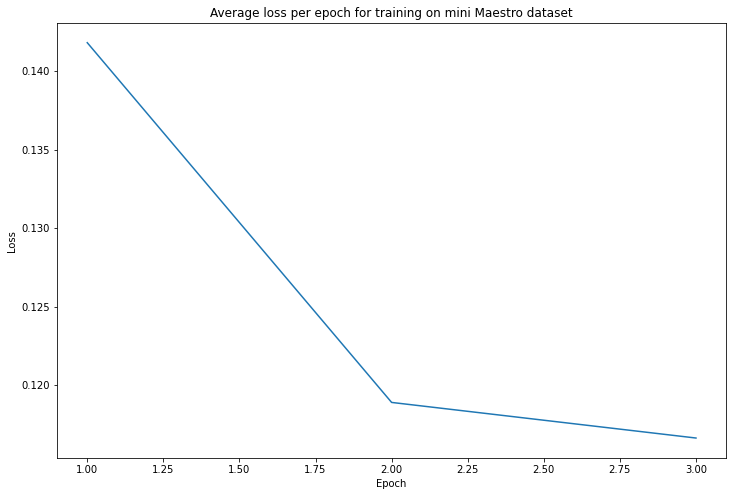

In [92]:
# Need some graphing code for evaluation of training
def plot_loss_history(loss_history, num_epochs, label='training'):
  epochs = [i+1 for i in range(num_epochs)]

  fig = plt.figure()
  fig.set_figwidth(12)
  fig.set_figheight(8)

  plt.plot(epochs, loss_history)

  plt.title('Average loss per epoch for {} on mini Maestro dataset'.format(label))
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.show()

plot_loss_history(train_loss_history, num_epochs, 'training')

In [93]:
# 'Conventional' TrebleTransformer. Some number of layers
# with some dimensions with output space the same as the vocab size.
actorNetwork = trebletransformer

# Only difference from the actor is the output is a single value.
# Why use the same network? So we can be confident it has the
# same capacity to understand what the heck a song is.
criticNetwork = TrebleTransformer(hidden_dims = hidden_dims,
                                  num_layers = num_layers,
                                  num_heads = num_heads,
                                  ffn_dims = ffn_dims,
                                  max_rel_dist = max_rel_dist,
                                  max_abs_pos = max_abs_position, 
                                  vocab_size = vocabulary_size, 
                                  bias = True,
                                  dropout = dropout_rate,
                                  epsilon_layernorm = epsilon_norm,
                                  output_size = 1
                                 )

# Add embedding and weights from trebletransformer to criticNetwork
criticNetwork.input_embedding = trebletransformer.input_embedding
criticNetwork.positional_encoding = trebletransformer.positional_encoding
criticNetwork.decoder = trebletransformer.decoder

actorNetwork = TTActorNetwork(actorNetwork)
criticNetwork = TTCriticNetwork(criticNetwork)
agent = Agent(actorNetwork, criticNetwork)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  


In [94]:
# ITS MUSIC TIME, FOOL
env = musicEnv(max_rel_dist, vocabulary_size)

N = 20

best_score = env.reward_range[0]
score_history = []

learn_iters = 0
avg_score = 0
n_steps = 0

for i in range(10000):
    observation = env.reset()
    done = False
    score = 0
    
    while not done:
        action, prob, val = agent.choose_action(observation)
        observation_, reward, done, info = env.step(action)
        n_steps += 1
        score += reward
        agent.remember(observation, action, prob, val, reward, done)
        if n_steps % N == 0:
            agent.learn()
            learn_iters += 1
        observation = observation_
        
    score_history.append(score)
    avg_score = np.mean(score_history[-100:])

    if avg_score > best_score:
        best_score = avg_score
        agent.save_models()
        
    print('episode', i, 'score %.1f' % score, 'avg score %.1f' % avg_score,
                'time_steps', n_steps, 'learning_steps', learn_iters)

Streaming output truncated to the last 5000 lines.
episode 5000 score 146.0 avg score 122.8 time_steps 245049 learning_steps 12252
episode 5001 score 144.0 avg score 122.9 time_steps 245098 learning_steps 12254
episode 5002 score 152.0 avg score 123.2 time_steps 245147 learning_steps 12257
episode 5003 score 156.0 avg score 123.7 time_steps 245196 learning_steps 12259
episode 5004 score 140.0 avg score 123.6 time_steps 245245 learning_steps 12262
episode 5005 score 172.0 avg score 124.1 time_steps 245294 learning_steps 12264
episode 5006 score 168.0 avg score 124.3 time_steps 245343 learning_steps 12267
episode 5007 score 156.0 avg score 124.3 time_steps 245392 learning_steps 12269
episode 5008 score 148.0 avg score 124.2 time_steps 245441 learning_steps 12272
episode 5009 score 156.0 avg score 124.7 time_steps 245490 learning_steps 12274
episode 5010 score 140.0 avg score 124.8 time_steps 245539 learning_steps 12276
episode 5011 score 112.0 avg score 124.3 time_steps 245588 learning_s

In [96]:
# GENERATION CODE WILL GO HERE
def generate_music(model, input_data, save_path, song_name, temp=1.0, num_samples=None, tempo=512820):

  print("Beginning music generation using decoding...")

  # MUSIC GENERATION / DECODING PHASE
  # Vocabulary defined based on Oore et. al 2018 used in vocab above
  note_on_vocab = [f"note_on_{i}" for i in range(128)]
  note_off_vocab = [f"note_off_{i}" for i in range(128)]
  time_shift_vocab = [f"time_shift_{i}" for i in range(125)]
  velocity_vocab = [f"set_velocity_{i}" for i in range(32)]
  num_midi_events = len(note_on_vocab) + len(note_off_vocab) + len(time_shift_vocab) + len(velocity_vocab)

  # Lines borrowed from spectraldoy repo
  vocab = ["<pad>"] + note_on_vocab + note_off_vocab + time_shift_vocab + velocity_vocab + ["<start>", "<end>"]
  vocab_size = len(vocab)
  print(vocab)

  # Get token vocabulary IDs for all MIDI events in the data
  input_indices = []
  for midi_event in input_data: 
    input_indices.append(vocab.index(midi_event))

  # Ensure start token is present as first token 
  if input_indices[0] != vocab.index("<start>"):
    input_indices = [vocab.index("<start>")] + input_indices
  
  input_indices = torch.tensor(input_indices, dtype=torch.int64)
  input_indices.unsqueeze(0)

  try:
    with torch.no_grad(): 
      end_reached = False
      while not end_reached: 
        #predicted = model(x=input_indices, x_mask=create_look_ahead_mask(len(input_indices)))
        predicted = model(x=input_indices, x_mask=create_mask(input_indices, input_indices.dim()+2))
        predicted /= temp(input_indices[-1].shape[-1])
        final_pred = torch.distributions.Categorical(logits=predicted[..., -1, :]).sample()

        if final_pred == vocab.index("<end>"):
          input_indices = input_indices.squeeze()
          end_reached = True 

        else: 
          input_indices = torch.cat([input_indices, final_pred.view(1, 1)], dim=-1)

  # Can't stop us 
  except (RuntimeError, KeyboardInterrupt):
    pass 

  final_notes = input_indices.squeeze().tolist()

  print("Generated {} tokens during music generation!".format(len(final_notes)))
  print("NOTE INDICES:")
  print(final_notes)

  # CONVERSION TO MIDI PHASE
  print("Beginning conversion to MIDI using generated sequences...")

  song_midi = tu.Listparser(index_list=final_notes, 
                            event_list=None, 
                            fname='test',
                            tempo=tempo
                            )
  
  # Save the MIDI file (in google drive)
  print("Saving MIDI file to save path...")

  song_midi.save(save_path + song_name +'.mid')